In [1]:
import scipy.io
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from spectral import imshow, view_cube
from matplotlib import patches
from spectral import spy_colors
from spectral import imshow as spyShow
import torch.nn.functional as F
import torch
import torch.nn.functional as F
from torch import nn
import torch
import tqdm
from sklearn.metrics import accuracy_score

C:\Users\Mati\anaconda3\envs\master\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## DATASET ANALYSIS

ImageView object:
  Display bands       :  (30, 20, 10)
  Interpolation       :  nearest
  RGB data limits     :
    R: [2272.0, 6366.0]
    G: [2560.0, 7271.0]
    B: [2700.0, 7990.0]

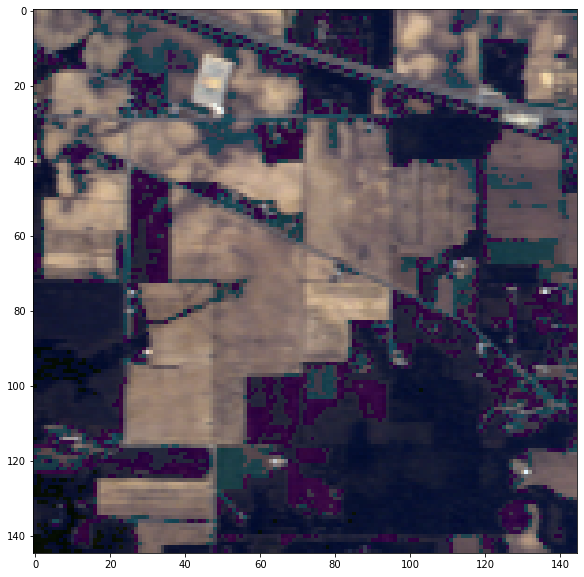

In [2]:
img = scipy.io.loadmat('./data/Indian_pines_corrected.mat')['indian_pines_corrected']
labels = scipy.io.loadmat('./data/Indian_pines_gt.mat')['indian_pines_gt']

imshow(img, (30, 20, 10), figsize=(10, 10), interpolation='nearest')

In [3]:
text_labels = np.array(['Unknown', 'Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
                        ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 
                        'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                        'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
                        'Stone-Steel-Towers'])

In [4]:
labels_dict = dict(zip(np.unique(labels), text_labels))

unique, counts = np.unique(labels, return_counts=True)

labels_distribution = dict(zip(unique, counts))

In [5]:
img.shape, np.unique(labels), np.unique(labels).shape, text_labels.shape

((145, 145, 200),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16],
       dtype=uint8),
 (17,),
 (17,))

In [6]:
labels_legend = [patches.Patch(color=spy_colors[x]/255.,
                 label=str(x) + ' - ' + labels_dict[x]) for x in np.unique(labels)]

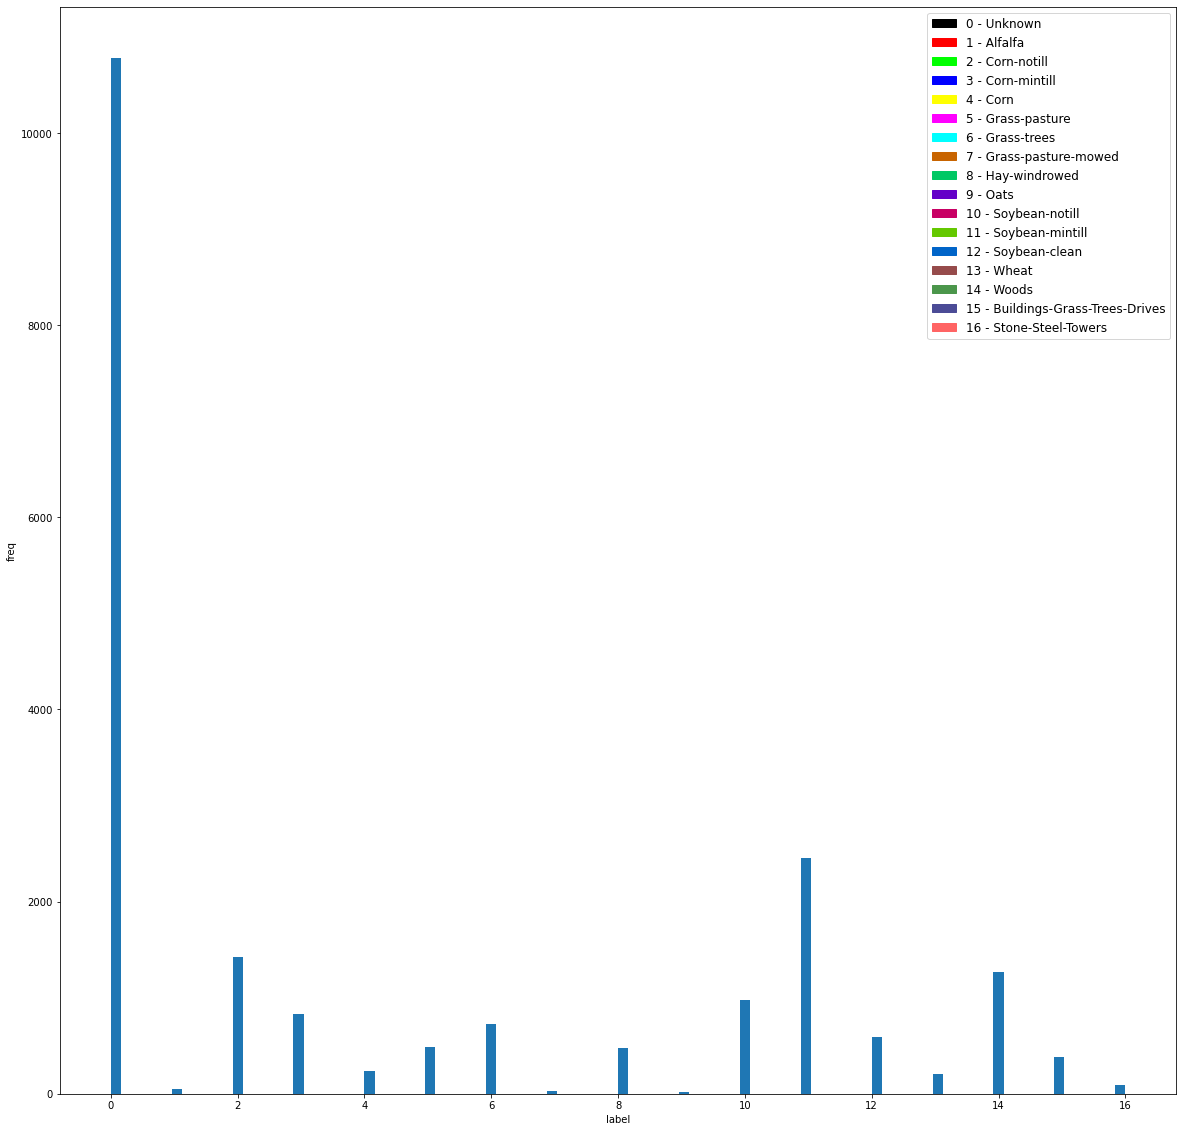

In [7]:
reshaped_labels = np.reshape(labels, len(labels) * len(labels[0]))
plt.figure(figsize=(20,20))
plt.hist(reshaped_labels, bins=100)
plt.ylabel('freq')
plt.xlabel('label');
plt.legend(handles=labels_legend, fontsize='large');

In [8]:
labels_distribution

{0: 10776,
 1: 46,
 2: 1428,
 3: 830,
 4: 237,
 5: 483,
 6: 730,
 7: 28,
 8: 478,
 9: 20,
 10: 972,
 11: 2455,
 12: 593,
 13: 205,
 14: 1265,
 15: 386,
 16: 93}

ImageView object:
  Interpolation       :  <default>

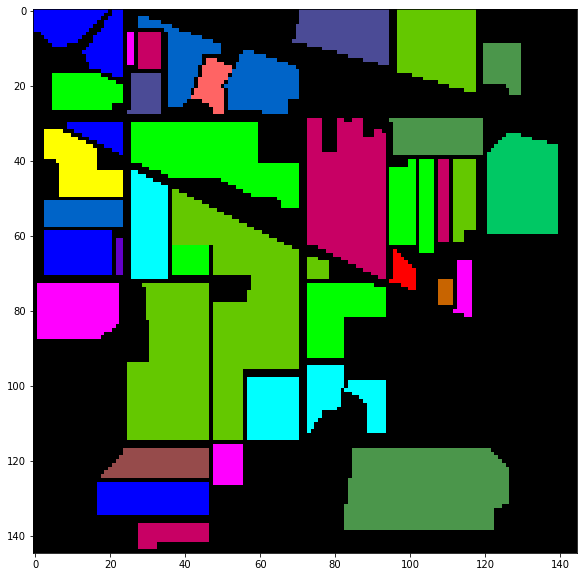

In [9]:
imshow(classes=labels, figsize=(10, 10))

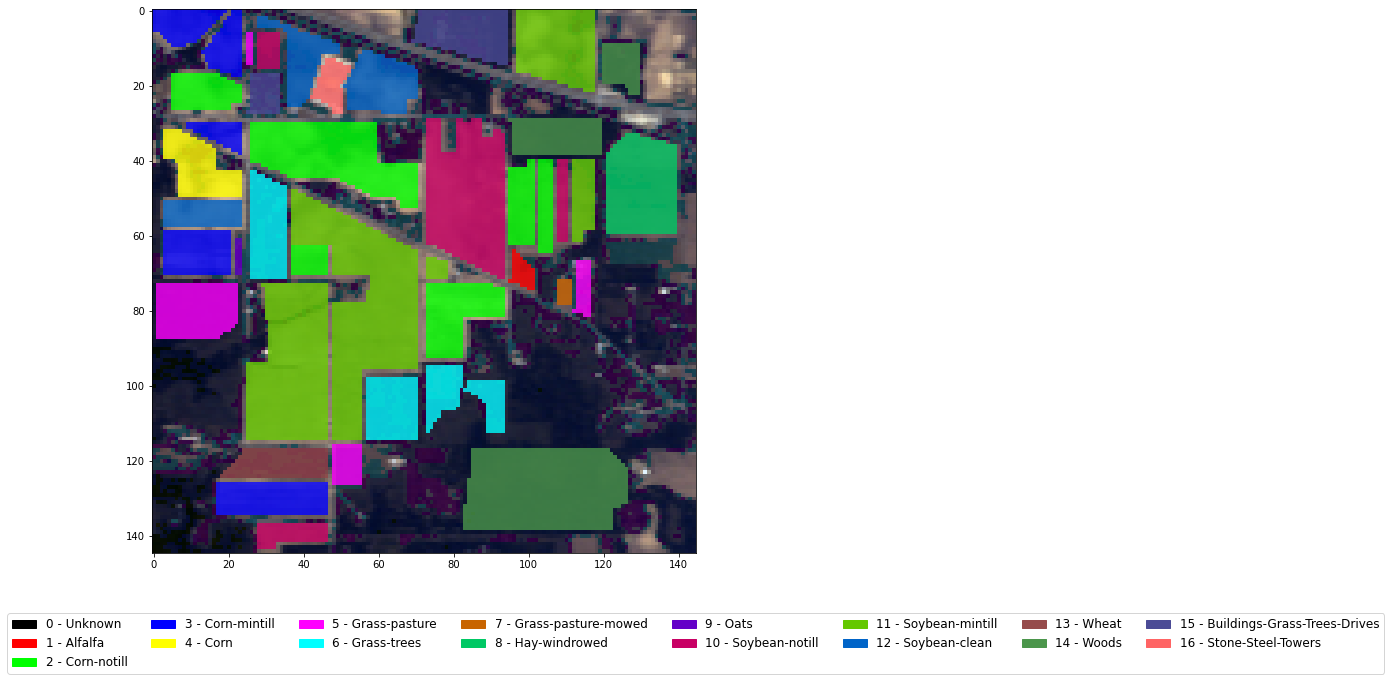

In [10]:
view = spyShow(data=img, bands=(30, 20, 10), classes=labels, fignum=1, interpolation='nearest',  figsize=(10, 10))
view.set_display_mode('overlay')
view.class_alpha = 0.8

plt.legend(handles=labels_legend, ncol=8, fontsize='large', 
           loc='upper center', bbox_to_anchor=(1, -0.1));

## HYPERPARAMETERS

In [11]:
WINDOW_SIZE = 25
EPOCHS = 10
NUM_OF_PRINCIPAL_COMPONENTS = 30
NUM_OF_LABELS = np.unique(labels).shape[0]

## PCA

In [12]:
def pca(num_components, img):
    reduced_img = np.reshape(img, (-1, img.shape[2]))
    pca_result = PCA(n_components=num_components, whiten=True)
    reduced_img = pca_result.fit_transform(reduced_img)
    reduced_img = np.reshape(reduced_img, (img.shape[0],img.shape[1], num_components))
    return reduced_img, pca_result

In [13]:
reduced_img, pca_result = pca(num_components=NUM_OF_PRINCIPAL_COMPONENTS, img=img)

ImageView object:
  Display bands       :  [0, 15.0, 29]
  Interpolation       :  <default>
  RGB data limits     :
    R: [-2.206083941595965, 2.5880770789733205]
    G: [-4.062529632154162, 5.775596202104884]
    B: [-5.379266896727658, 5.558356146247395]

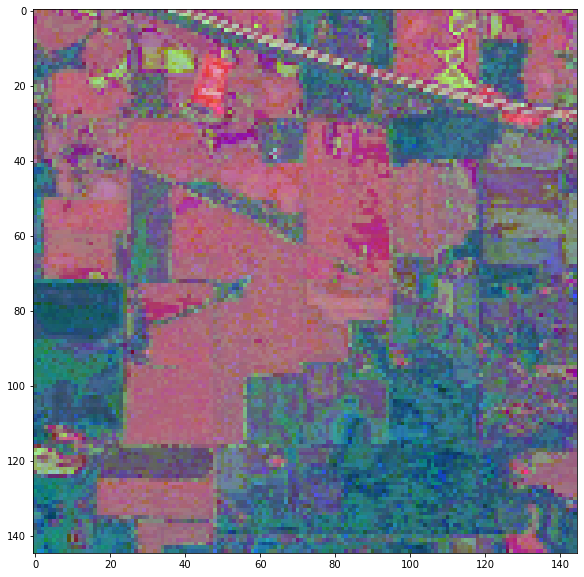

In [14]:
imshow(reduced_img, figsize=(10, 10))

## DATASET

In [15]:
def prepareDataset(image, labels):
    windowFill = [int((WINDOW_SIZE - 1)/2) for i in range(0, 4)]
    withPadding = F.pad(image, (0, 0, *windowFill))
    withPadding = withPadding.permute((-1,0,1))
    withPadding = withPadding.unfold(1,WINDOW_SIZE,1).unfold(2,WINDOW_SIZE,1)
    withPadding = withPadding.reshape(withPadding.shape[0],-1,*withPadding.shape[3:])
    withPadding = withPadding.permute((1,2,3,0))
    samples = withPadding
    labels = torch.flatten(labels)
    return samples, labels

In [16]:
# use from lib / built-in
def normalize(image):
    mean = image.mean(0, keepdim=True)
    standard = image.std(0, unbiased=False, keepdim=True)
    image -= mean
    image /= standard
    return image

## MODEL

In [17]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv_1 = torch.nn.Conv3d(1,8,(3,3,7), stride=(1, 1, 1))
        self.conv_2 = torch.nn.Conv3d(8, 16,(3,3,5),stride=(1,1,1))
        self.conv_3 = torch.nn.Conv3d(16,32,(3,3,3), stride=(1, 1, 1))
        self.conv_4 = torch.nn.Conv2d(576,64,(3,3), stride=(1, 1))
        self.flatten = torch.nn.Flatten()
        self.dense_1 = torch.nn.Linear(in_features=18496,out_features=256)
        self.dropout_1 = torch.nn.Dropout(p=0.4)
        self.dense_2 = torch.nn.Linear(in_features=256,out_features=128)
        self.dropout_2 = torch.nn.Dropout(p=0.4)
        self.dense_3 = torch.nn.Linear(in_features=128,out_features=NUM_OF_LABELS)
        self.log_softmax = torch.nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        x = torch.unsqueeze(x,1)
        x = self.conv_1(x)
        x = F.relu(x)
        x = self.conv_2(x)
        x = F.relu(x)
        x = self.conv_3(x)
        x = F.relu(x)
        x = x.permute((0,2,3,1,4))
        x = x.reshape((*x.shape[:3],-1))
        x = x.permute((0,3,1,2))
        x = self.conv_4(x)
        x = F.relu(x)
        x = self.flatten(x)
        x = self.dense_1(x)
        x = F.relu(x)
        x = self.dropout_1(x)
        x = self.dense_2(x)
        x = F.relu(x)
        x = self.dropout_2(x)
        x = self.dense_3(x)
        x = self.log_softmax(x)
        return x

    def train_model(self, X, y, device, batch_size = 256, epochs = 100, validation_data = [], callbacks = []):
        loss = nn.NLLLoss()
        optimizer = torch.optim.Adam(self.parameters(),lr=0.001)
        losses_epochs = []
        scores = []
        if validation_data:
            scores_val = []
        for _ in tqdm.tqdm(range(epochs)):
            for idx in range(0,len(y) - batch_size,batch_size):
                optimizer.zero_grad()
                temp_X, temp_y = X[idx:idx+batch_size].to(device), y[idx:idx+batch_size].to(device)
                res = self.forward(temp_X)
                output = loss(res, temp_y.long())
                output.backward()
                optimizer.step()
            losses_epochs.append(output.item())
            scores.append(self.score(X,y,device, batch_size))
            if validation_data:
                scores_val.append(self.score(validation_data[0], validation_data[1], device, batch_size))
        if validation_data:
            return losses_epochs, scores, scores_val
        else:
            return losses_epochs, scores
        
    def score(self, X_test , y_test, device, batch_size = 256, verbose = True):
        self.train(False)
        scores = []
        device_cpu = torch.device('cpu')
        with torch.no_grad():
            for idx in tqdm.tqdm(range(0,len(y_test) - batch_size,batch_size)):
                temp_X, temp_y = X_test[idx:idx+batch_size].to(device), y_test[idx:idx+batch_size].to(device)
                res = self(temp_X)
                scores.append(torch.argmax(torch.exp(res.to(device_cpu)),axis=1))
        accuracy_scores = []
        for idx in tqdm.tqdm(range(0,len(y_test) - batch_size,batch_size)):
            accuracy_scores.append(accuracy_score(y_test[idx:idx+batch_size],scores[int(idx/batch_size)]))
        self.train(True)
        return sum(accuracy_scores)/len(accuracy_scores)

In [18]:
reduced_img, pca_result

tensor_img, tensor_labels = torch.Tensor(reduced_img.astype(int)), torch.Tensor(labels.astype(int))
normalized_img = normalize(tensor_img)
samples, labels = prepareDataset(normalized_img, tensor_labels)

In [19]:
from random import shuffle

labels = labels.long()
indices = list(range(len(labels)))
shuffle(indices)
samples_ = samples[indices]
labels_ = labels[indices]
split_index = int(len(samples)*0.4)
X_train, X_test, y_train, y_test = samples_[:split_index],samples[split_index:],labels_[:split_index],labels[split_index:]

In [20]:
model = Network()
device_cpu = torch.device('cpu')
device_gpu = torch.device("cuda:0")
model.to(device_gpu)

Network(
  (conv_1): Conv3d(1, 8, kernel_size=(3, 3, 7), stride=(1, 1, 1))
  (conv_2): Conv3d(8, 16, kernel_size=(3, 3, 5), stride=(1, 1, 1))
  (conv_3): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (conv_4): Conv2d(576, 64, kernel_size=(3, 3), stride=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dense_1): Linear(in_features=18496, out_features=256, bias=True)
  (dropout_1): Dropout(p=0.4, inplace=False)
  (dense_2): Linear(in_features=256, out_features=128, bias=True)
  (dropout_2): Dropout(p=0.4, inplace=False)
  (dense_3): Linear(in_features=128, out_features=17, bias=True)
  (log_softmax): LogSoftmax(dim=1)
)

In [21]:
losses_epochs, scores, val_scores = model.train_model(X_train, y_train, device_gpu, epochs = EPOCHS, validation_data = [X_test, y_test])

100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 14.08it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 5332.45it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 13.50it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 14.15it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 6399.55it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 13.19it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 14.17it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 5330.12it/s]

100%|███████████████████████████

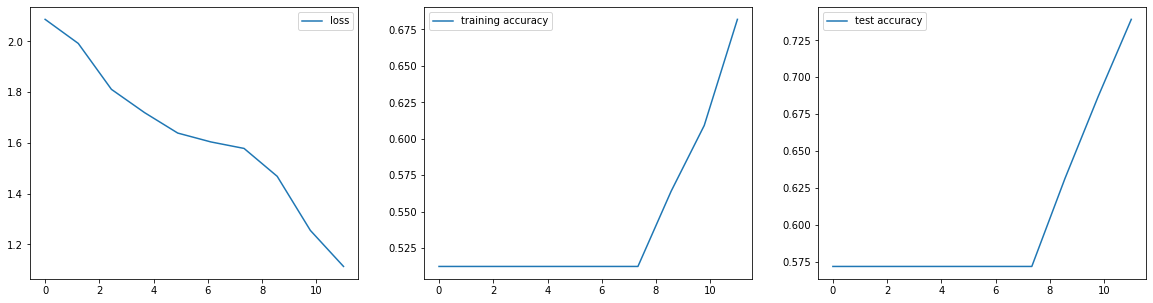

In [22]:
plt.figure(figsize=(20,5))
x = np.linspace(0, EPOCHS + 1, EPOCHS)

plt.subplot(131)
plt.plot(x, losses_epochs, label = 'loss')
plt.legend()
plt.subplot(132)
plt.plot(x, scores, label = 'training accuracy')
plt.legend()
plt.subplot(133)
plt.plot(x, val_scores, label = 'test accuracy')
plt.legend()
plt.show()

In [26]:
batch_size = 12
net = model.to(device_gpu)
num_its = len(samples) // 12 + 1
results = []
for i in range(num_its):
    batch_X = samples[i * batch_size : (i+1)*batch_size].to(device_gpu)
    predictions = net(batch_X)
    predictions = torch.argmax(predictions, axis = 1)
    results.extend(predictions)

In [27]:
results = [res.item() for res in results]

In [28]:
results = np.array(results).reshape((145,145)) / max(results)

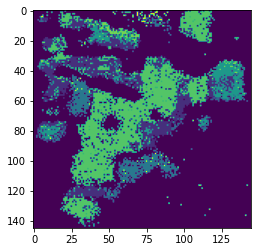

In [29]:
plt.imshow(results)

In [30]:
results, results.shape

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 (145, 145))

In [31]:
y = np.array(labels)
y = y.reshape((145,145)) / y.max()

In [32]:
torch.numel(torch.tensor(labels))

C:\Users\Mati\AppData\Local\Temp/ipykernel_5936/1049173826.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.numel(torch.tensor(labels))


21025

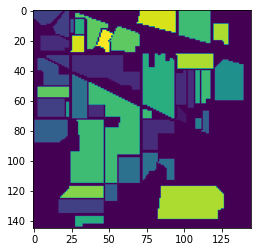

In [33]:
plt.imshow(y)

In [34]:
results_flat = results.flatten()
labels_flat = y.flatten()

In [35]:
(y ==results).sum()/np.prod(results.shape)

0.47205707491082044